In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd

# Font size variables for plotting
TITLE_FONTSIZE = 22
LABEL_FONTSIZE = 18
TICK_FONTSIZE = 16
LEGEND_FONTSIZE = 16

# Colormap for plotting
COLORMAP = cm.jet

def get_rd_farrell(mua, musp, n):
    """
    Calculate the diffuse reflectance (Rd) using Farrell's model.

    Parameters:
    - mua: numpy array, absorption coefficient (cm^-1)
    - musp: numpy array, reduced scattering coefficient (cm^-1)
    - n: float, refractive index ratio of the medium

    Returns:
    - Rd: numpy array, diffuse reflectance
    """
    # Calculate the internal reflectance based on refractive index
    ri = 0.6681 + 0.0636 * n + 0.7099 / n - 1.4399 / n**2
    A = (1 + ri) / (1 - ri)
    
    # Calculate optical parameters
    zo = 1 / (mua + musp)  # Penetration depth
    D = zo / 3  # Diffusion coefficient
    delta = np.sqrt(D / mua)  # Photon mean free path
    mueff = 1 / delta  # Effective attenuation coefficient
    ap = musp / (mua + musp)  # Albedo
    
    # Calculate the diffuse reflectance
    Rd = ap * np.exp(-mueff * zo) / 2 * (1 + np.exp(-4 / 3 * A * np.sqrt(3 * (1 - ap))))
    return Rd

def load_spectral_data(filename='AbsorptionScatteringCoefficients.mat'):
    """
    Load spectral data from a .mat file.

    Parameters:
    - filename: str, name of the .mat file

    Returns:
    - nmLIB: numpy array, wavelengths (nm)
    - MU: numpy array, absorption and scattering coefficients
    """
    # Load the .mat file
    mat_data = sio.loadmat(filename)
    nmLIB = mat_data['nmLIB'].flatten()  # Extract wavelengths
    MU = mat_data['MU']  # Extract absorption and scattering coefficients
    return nmLIB, MU

def filter_wavelengths(nmLIB, mua, musp, min_wl=400, max_wl=800):
    """
    Filter the wavelengths within a specified range.

    Parameters:
    - nmLIB: numpy array, wavelengths (nm)
    - mua: numpy array, absorption coefficient (cm^-1)
    - musp: numpy array, reduced scattering coefficient (cm^-1)
    - min_wl: int, minimum wavelength (nm)
    - max_wl: int, maximum wavelength (nm)

    Returns:
    - nmLIB_filtered: numpy array, filtered wavelengths (nm)
    - mua_filtered: numpy array, filtered absorption coefficient (cm^-1)
    - musp_filtered: numpy array, filtered reduced scattering coefficient (cm^-1)
    """
    # Create a mask for the specified wavelength range
    mask = (nmLIB >= min_wl) & (nmLIB <= max_wl)
    # Apply the mask to filter the data
    nmLIB_filtered = nmLIB[mask]
    mua_filtered = mua[mask]
    musp_filtered = musp[mask]
    return nmLIB_filtered, mua_filtered, musp_filtered

def draw_gradient_background(fig, color1, color2):
    """
    Draw a gradient background for the plot.

    Parameters:
    - fig: matplotlib figure object
    - color1: str, starting color of the gradient
    - color2: str, ending color of the gradient
    """
    # Create a gradient array
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))
    # Create a custom colormap
    cmap = LinearSegmentedColormap.from_list('gradient', [color1, color2])

    # Add a background axis to the figure
    ax_background = fig.add_axes([0, 0, 1, 1], label='background', zorder=-1)
    # Display the gradient
    ax_background.imshow(gradient, aspect='auto', cmap=cmap, interpolation='none')
    ax_background.axis('off')  # Hide the axis

def plot_spectra(nmLIB, reflectances, labels, title='Reflectance Spectrum of Skin\n', xlabel='\nWavelength (nm)', ylabel='Reflectance (Rd)\n', use_gradient=False):
    """
    Plot reflectance spectra.

    Parameters:
    - nmLIB: numpy array, wavelengths (nm)
    - reflectances: list of numpy arrays, reflectance values for different spectra
    - labels: list of str, labels for the spectra
    - title: str, title of the plot
    - xlabel: str, label for the x-axis
    - ylabel: str, label for the y-axis
    - use_gradient: bool, whether to use gradient background or not
    """
    fig, ax = plt.subplots(figsize=(18, 10))
    
    if use_gradient:
        # Draw a gradient background
        draw_gradient_background(fig, '#b4c8d9', 'white')
    
    # Plot each reflectance spectrum with a unique color
    colors = COLORMAP(np.linspace(0, 1, len(reflectances)))
    for reflectance, label, color in zip(reflectances, labels, colors):
        ax.plot(nmLIB, reflectance, label=label, color=color)
    
    # Set plot labels and title
    ax.set_xlabel(xlabel, fontsize=LABEL_FONTSIZE)
    ax.set_ylabel(ylabel, fontsize=LABEL_FONTSIZE)
    ax.set_title(title, fontsize=TITLE_FONTSIZE)
    ax.legend(facecolor='#f0f0f0', fontsize=LEGEND_FONTSIZE)  # Set the legend background to a lighter gray
    ax.grid(True)
    ax.set_facecolor('white')  # Set the plot background to white

    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
    
    # Display the plot
    plt.show()

def save_data(nmLIB, reflectances, labels, params, filename):
    """
    Save the reflectance data and parameters to a file.

    Parameters:
    - nmLIB: numpy array, wavelengths (nm)
    - reflectances: list of numpy arrays, reflectance values for different spectra
    - labels: list of str, labels for the spectra
    - params: dict, parameters used in the simulation
    - filename: str, name of the file to save the data

    Raises:
    - ValueError: if the filename does not end with '.csv' or '.mat'
    """
    # Create a dictionary to store the data
    data = {'Wavelength (nm)': nmLIB}
    for reflectance, label in zip(reflectances, labels):
        data[label] = reflectance

    # Convert parameters dictionary to a DataFrame
    params_df = pd.DataFrame([params])

    # Combine data and parameters into a single DataFrame
    combined_df = pd.concat([params_df, pd.DataFrame(data)], axis=1)

    # Save the DataFrame to a file
    if filename.endswith('.csv'):
        combined_df.to_csv(filename, index=False)
    elif filename.endswith('.mat'):
        sio.savemat(filename, {'data': combined_df.to_dict('list')})
    else:
        raise ValueError("Filename must end with '.csv' or '.mat'")

def calculate_mua(MU, params, nmLIB):
    """
    Calculate the absorption coefficient (mua) based on given parameters.

    Parameters:
    - MU: numpy array, absorption and scattering coefficients from the spectral library
    - params: dict, parameters used in the simulation
    - nmLIB: numpy array, wavelengths (nm)

    Returns:
    - mua: numpy array, absorption coefficient (cm^-1)
    """
    # Constants for melanin absorption
    alpha_melanin = 6.6
    beta_melanin = 3.33
    melanin_absorption = alpha_melanin * nmLIB ** -beta_melanin

    # Calculate the total absorption coefficient
    mua = MU[:, 0] * params['blood_content'] * params['oxygen_saturation'] + \
          MU[:, 1] * params['blood_content'] * (1 - params['oxygen_saturation']) + \
          MU[:, 2] * params['water_content'] + \
          melanin_absorption * params['melanin_content'] + \
          MU[:, 4] * params['collagen_content']  # cm^-1, absorption coefficient
    return mua

def default_musp(nmLIB):
    """
    Calculate the reduced scattering coefficient (musp) based on a power law model.

    Parameters:
    - nmLIB: numpy array, wavelengths (nm)

    Returns:
    - musp: numpy array, reduced scattering coefficient (cm^-1)
    """
    a = 20  # cm^-1, scattering strength at 500 nm
    b = 1.5  # scattering power
    musp = a * (nmLIB / 500) ** -b  # cm^-1, reduced scattering coefficient
    return musp

def plot_single_spectrum(params, nmLIB, MU, save=False, save_filename=None, only_save=False, show_params=False, use_gradient=False):
    """
    Plot a single reflectance spectrum based on the given parameters.

    Parameters:
    - params: dict, parameters used in the simulation
    - nmLIB: numpy array, wavelengths (nm)
    - MU: numpy array, absorption and scattering coefficients from the spectral library
    - save: bool, whether to save the data to a file
    - save_filename: str, name of the file to save the data
    - only_save: bool, whether to only save the data without plotting
    - show_params: bool, whether to show parameter values in the legend
    - use_gradient: bool, whether to use gradient background or not
    """
    # Calculate the absorption and scattering coefficients
    mua = calculate_mua(MU, params, nmLIB)
    musp = default_musp(nmLIB)
    # Filter the wavelengths
    nmLIB_filtered, mua_filtered, musp_filtered = filter_wavelengths(nmLIB, mua, musp)
    # Calculate the reflectance
    reflectance = get_rd_farrell(mua_filtered, musp_filtered, params['refractive_index_ratio'])

    # Create a label with parameter values if show_params is True
    if show_params:
        label = 'Single Spectrum\n\n' + '\n'.join(f'{key}: {value:.2f}' for key, value in params.items() if key != 'refractive_index_ratio')
    else:
        label = 'Single Spectrum'

    # Save the data if required
    if save and save_filename:
        save_data(nmLIB_filtered, [reflectance], [label], params, save_filename)
    # Plot the spectrum if not only saving the data
    if not only_save:
        plot_spectra(nmLIB_filtered, [reflectance], [label], use_gradient=use_gradient)

def plot_varying_parameter(param_name, min_value, max_value, num_steps, nmLIB, MU, default_params, save=False, save_filename=None, only_save=False, use_gradient=False):
    """
    Plot reflectance spectra by varying a single parameter.

    Parameters:
    - param_name: str, name of the parameter to vary
    - min_value: float, minimum value of the parameter
    - max_value: float, maximum value of the parameter
    - num_steps: int, number of steps for varying the parameter
    - nmLIB: numpy array, wavelengths (nm)
    - MU: numpy array, absorption and scattering coefficients from the spectral library
    - default_params: dict, default parameters used in the simulation
    - save: bool, whether to save the data to a file
    - save_filename: str, name of the file to save the data
    - only_save: bool, whether to only save the data without plotting
    - use_gradient: bool, whether to use gradient background or not
    """
    # Create a copy of the default parameters
    params = default_params.copy()
    reflectances = []
    labels = []

    # Generate values for the parameter within the specified range
    param_values = np.linspace(min_value, max_value, num_steps)
    for value in param_values:
        params[param_name] = value

        # Calculate the absorption and scattering coefficients
        mua = calculate_mua(MU, params, nmLIB)
        musp = default_musp(nmLIB)
        # Filter the wavelengths
        nmLIB_filtered, mua_filtered, musp_filtered = filter_wavelengths(nmLIB, mua, musp)
        # Calculate the reflectance
        reflectance = get_rd_farrell(mua_filtered, musp_filtered, params['refractive_index_ratio'])

        reflectances.append(reflectance)
        labels.append(f'{param_name.capitalize()} {value:.2f}')

    # Save the data if required
    if save and save_filename:
        save_data(nmLIB_filtered, reflectances, labels, params, save_filename)
    # Plot the spectra if not only saving the data
    if not only_save:
        plot_spectra(nmLIB_filtered, reflectances, labels, title=f'Reflectance Spectrum of Skin for Varying {param_name.capitalize()}\n', use_gradient=use_gradient)

def plot_varying_multiple_parameters(param_ranges, nmLIB, MU, default_params, save=False, save_filename=None, only_save=False, use_gradient=False):
    """
    Plot reflectance spectra by varying multiple parameters.

    Parameters:
    - param_ranges: dict, ranges for the parameters to vary (min_value, max_value, num_steps)
    - nmLIB: numpy array, wavelengths (nm)
    - MU: numpy array, absorption and scattering coefficients from the spectral library
    - default_params: dict, default parameters used in the simulation
    - save: bool, whether to save the data to a file
    - save_filename: str, name of the file to save the data
    - only_save: bool, whether to only save the data without plotting
    - use_gradient: bool, whether to use gradient background or not
    """
    # Create a copy of the default parameters
    params = default_params.copy()
    reflectances = []
    labels = []
    all_params = []

    # Generate values for each parameter within the specified ranges
    param_names = list(param_ranges.keys())
    param_values_list = [np.linspace(r[0], r[1], r[2]) for r in param_ranges.values()]

    # Iterate over all combinations of parameter values
    for values in zip(*param_values_list):
        for param_name, value in zip(param_names, values):
            params[param_name] = value

        # Calculate the absorption and scattering coefficients
        mua = calculate_mua(MU, params, nmLIB)
        musp = default_musp(nmLIB)
        # Filter the wavelengths
        nmLIB_filtered, mua_filtered, musp_filtered = filter_wavelengths(nmLIB, mua, musp)
        # Calculate the reflectance
        reflectance = get_rd_farrell(mua_filtered, musp_filtered, params['refractive_index_ratio'])

        # Create a label for the current combination of parameter values
        label = ', '.join(f'{param_name.capitalize()} {value:.2f}' for param_name, value in zip(param_names, values))
        reflectances.append(reflectance)
        labels.append(label)
        all_params.append(params.copy())

    # Save the data if required
    if save and save_filename:
        for i, params in enumerate(all_params):
            params['label'] = labels[i]
        save_data(nmLIB_filtered, reflectances, labels, {'params': all_params}, save_filename)
    # Plot the spectra if not only saving the data
    if not only_save:
        plot_spectra(nmLIB_filtered, reflectances, labels, title='Reflectance Spectrum of Skin for Varying Multiple Parameters\n', use_gradient=use_gradient)



# Plot a single spectrum with defined default parameters

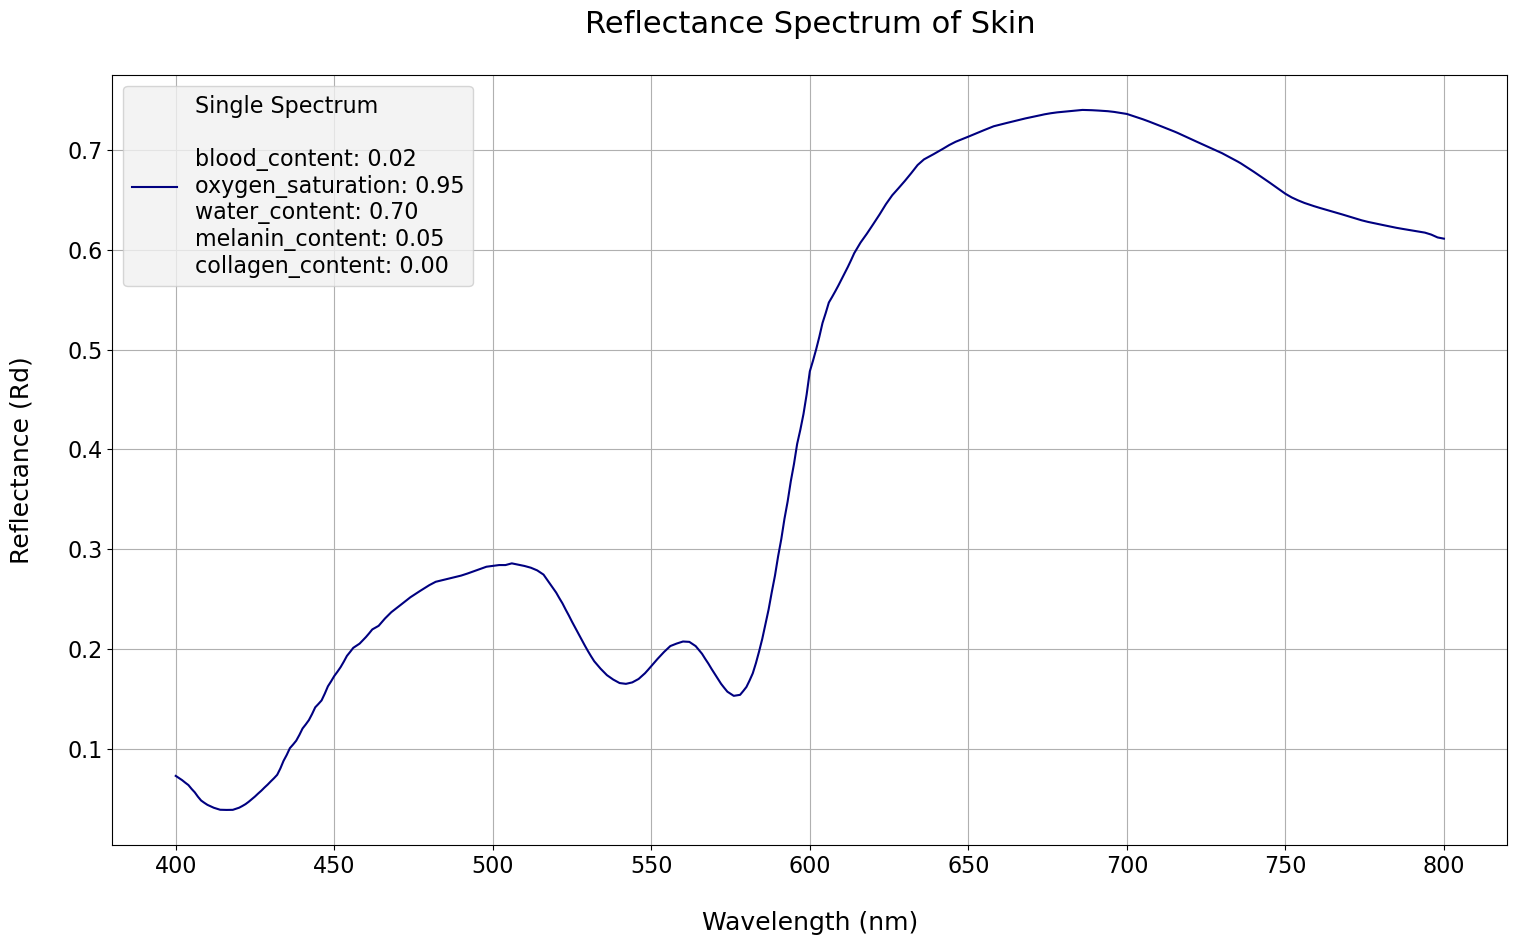

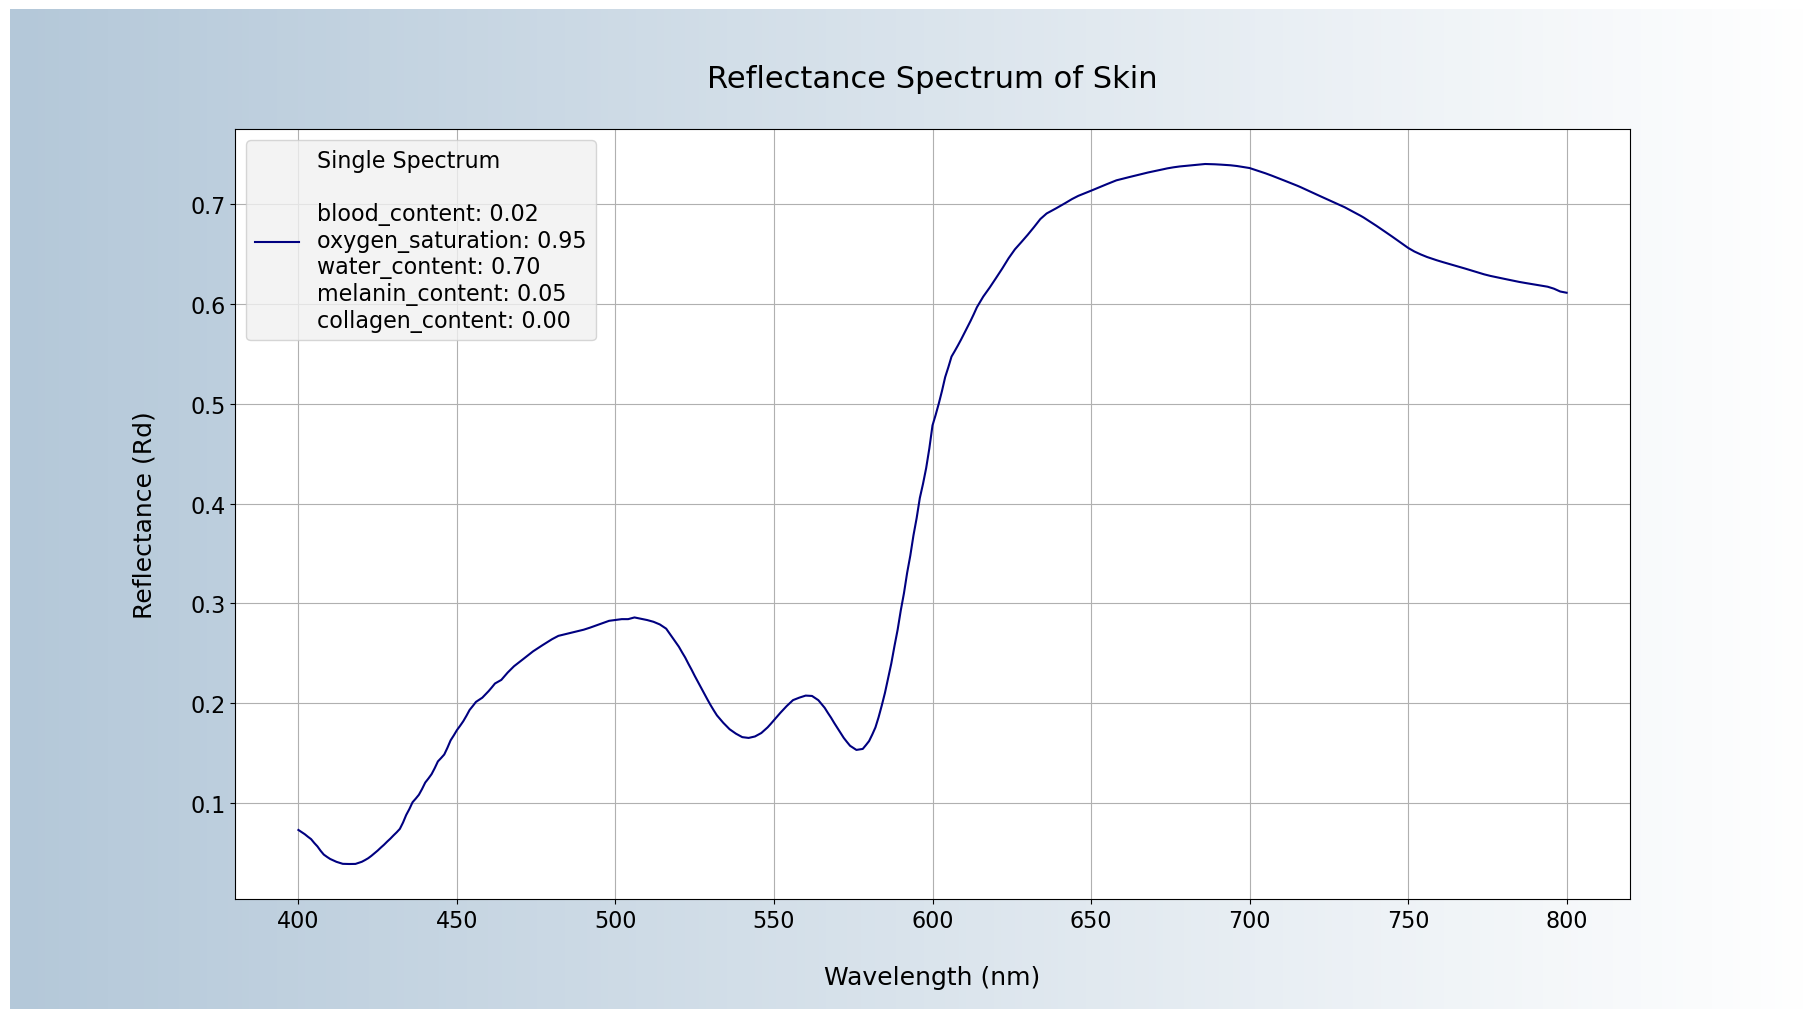

In [6]:
# Load spectral data
nmLIB, MU = load_spectral_data()

# Default parameters
default_params = {
    'blood_content': 0.02,  # 2% Blood content
    'oxygen_saturation': 0.95,  # 95% Oxygen saturation
    'water_content': 0.70,  # 70% Water content
    'refractive_index_ratio': 1.4,  # Refractive index ratio
    'melanin_content': 0.05,  # 5% Melanin content
    'collagen_content': 0.0  # 0% Collagen content
}

# ---------------- Examples of how to use the functions --------------------------

# Plot a single spectrum with default parameters and show parameter values, without gradient
plot_single_spectrum(default_params, nmLIB, MU, show_params=True, use_gradient=False)

# Plot a single spectrum with default parameters and show parameter values, with gradient
plot_single_spectrum(default_params, nmLIB, MU, show_params=True, use_gradient=True)

# Plot spectra varying a single parameter

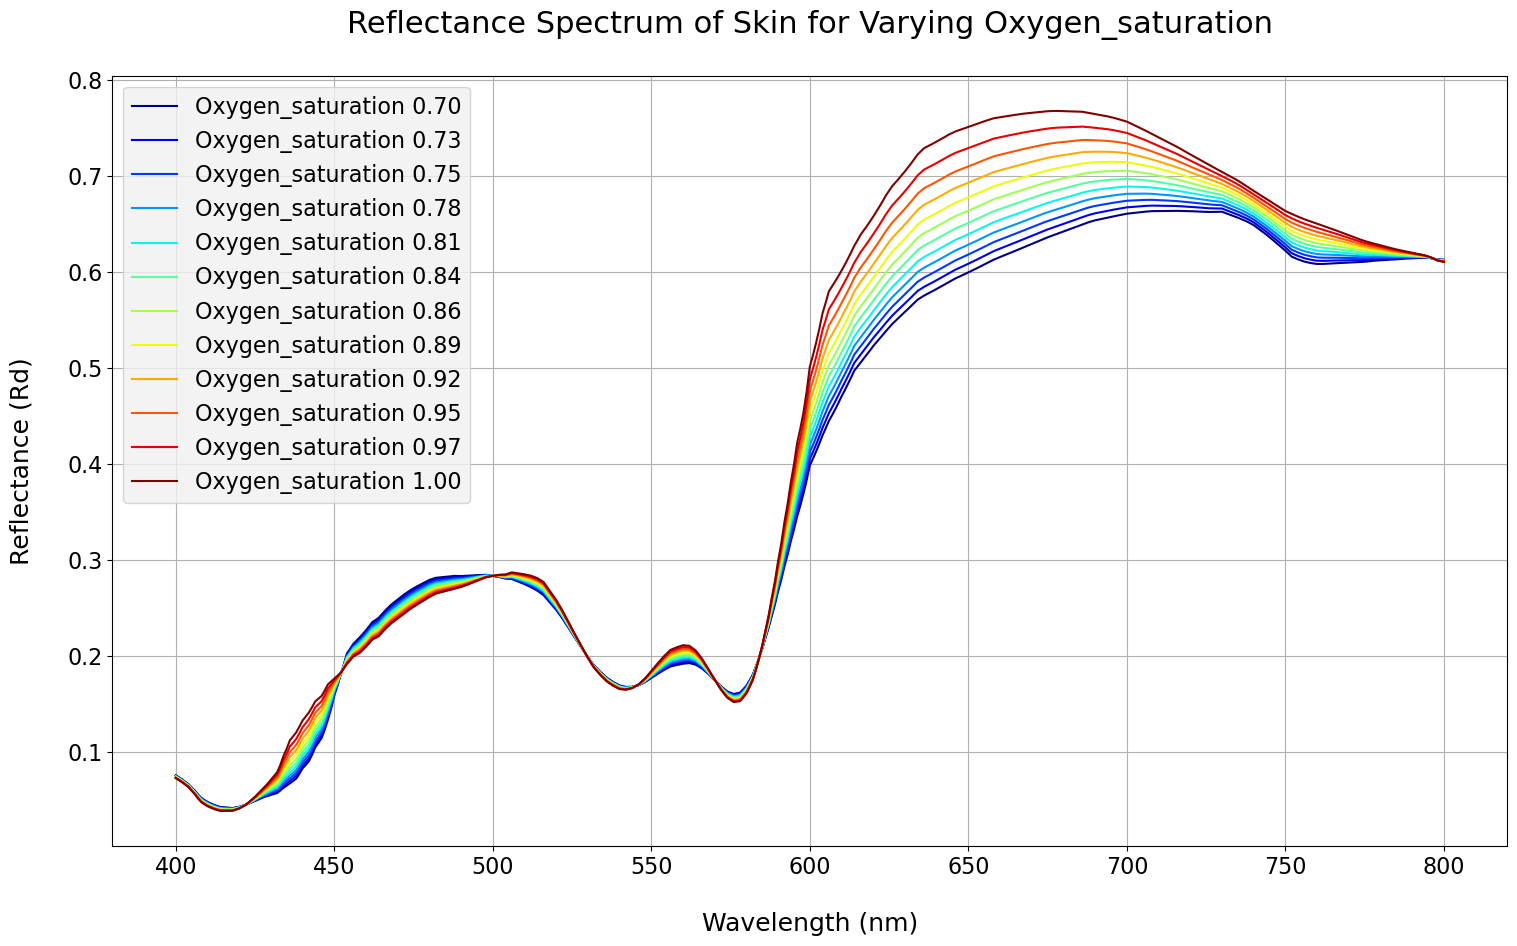

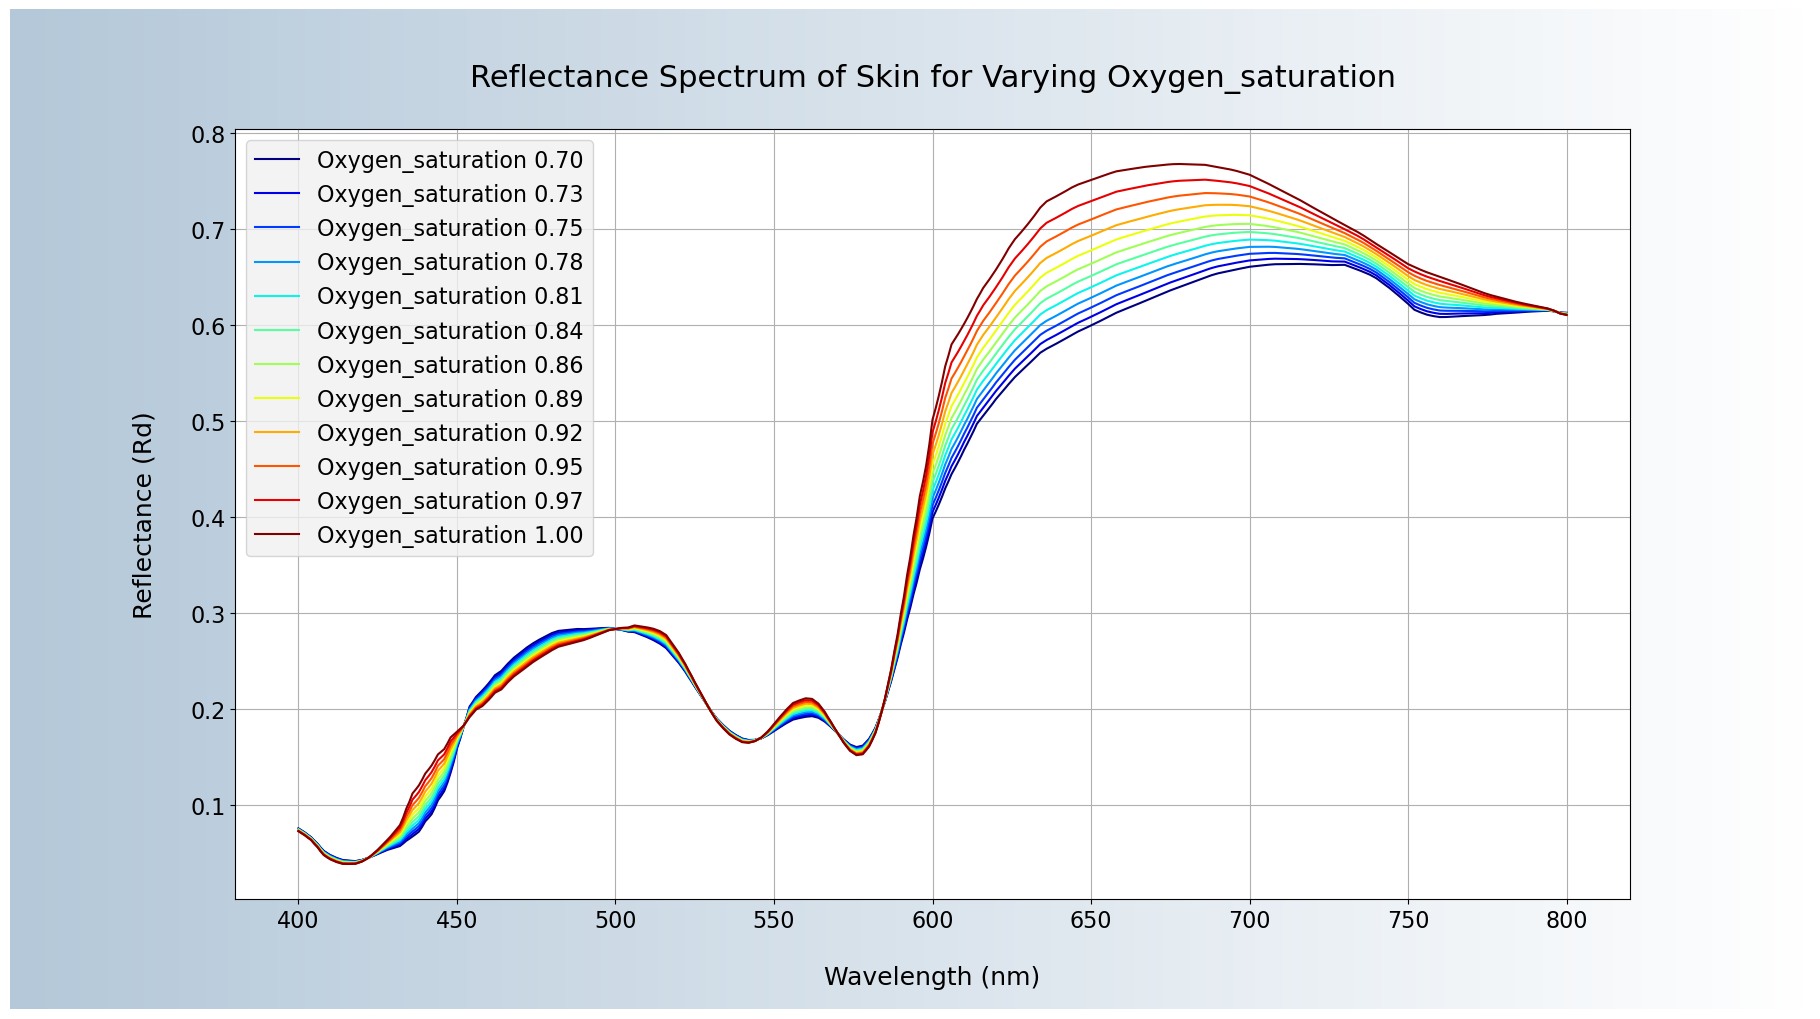

In [7]:
# Plot spectra varying a single parameter, without gradient
plot_varying_parameter('oxygen_saturation', 0.7, 1.0, 12, nmLIB, MU, default_params, use_gradient=False)

# Plot spectra varying a single parameter, with gradient
plot_varying_parameter('oxygen_saturation', 0.7, 1.0, 12, nmLIB, MU, default_params, use_gradient=True)


# Plot spectra varying multiple parameters

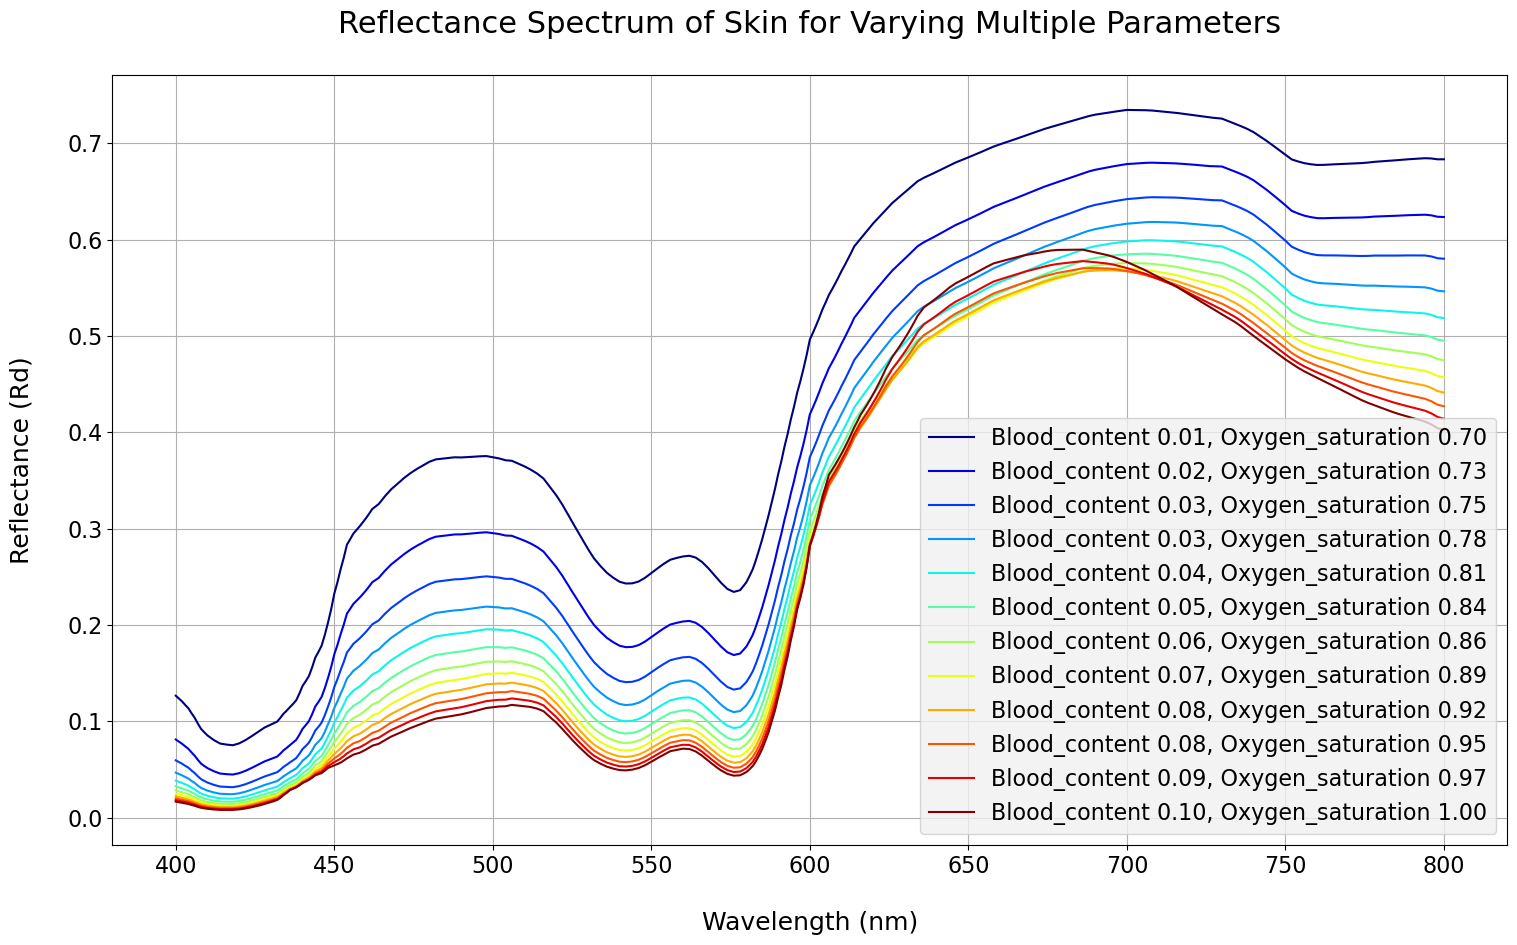

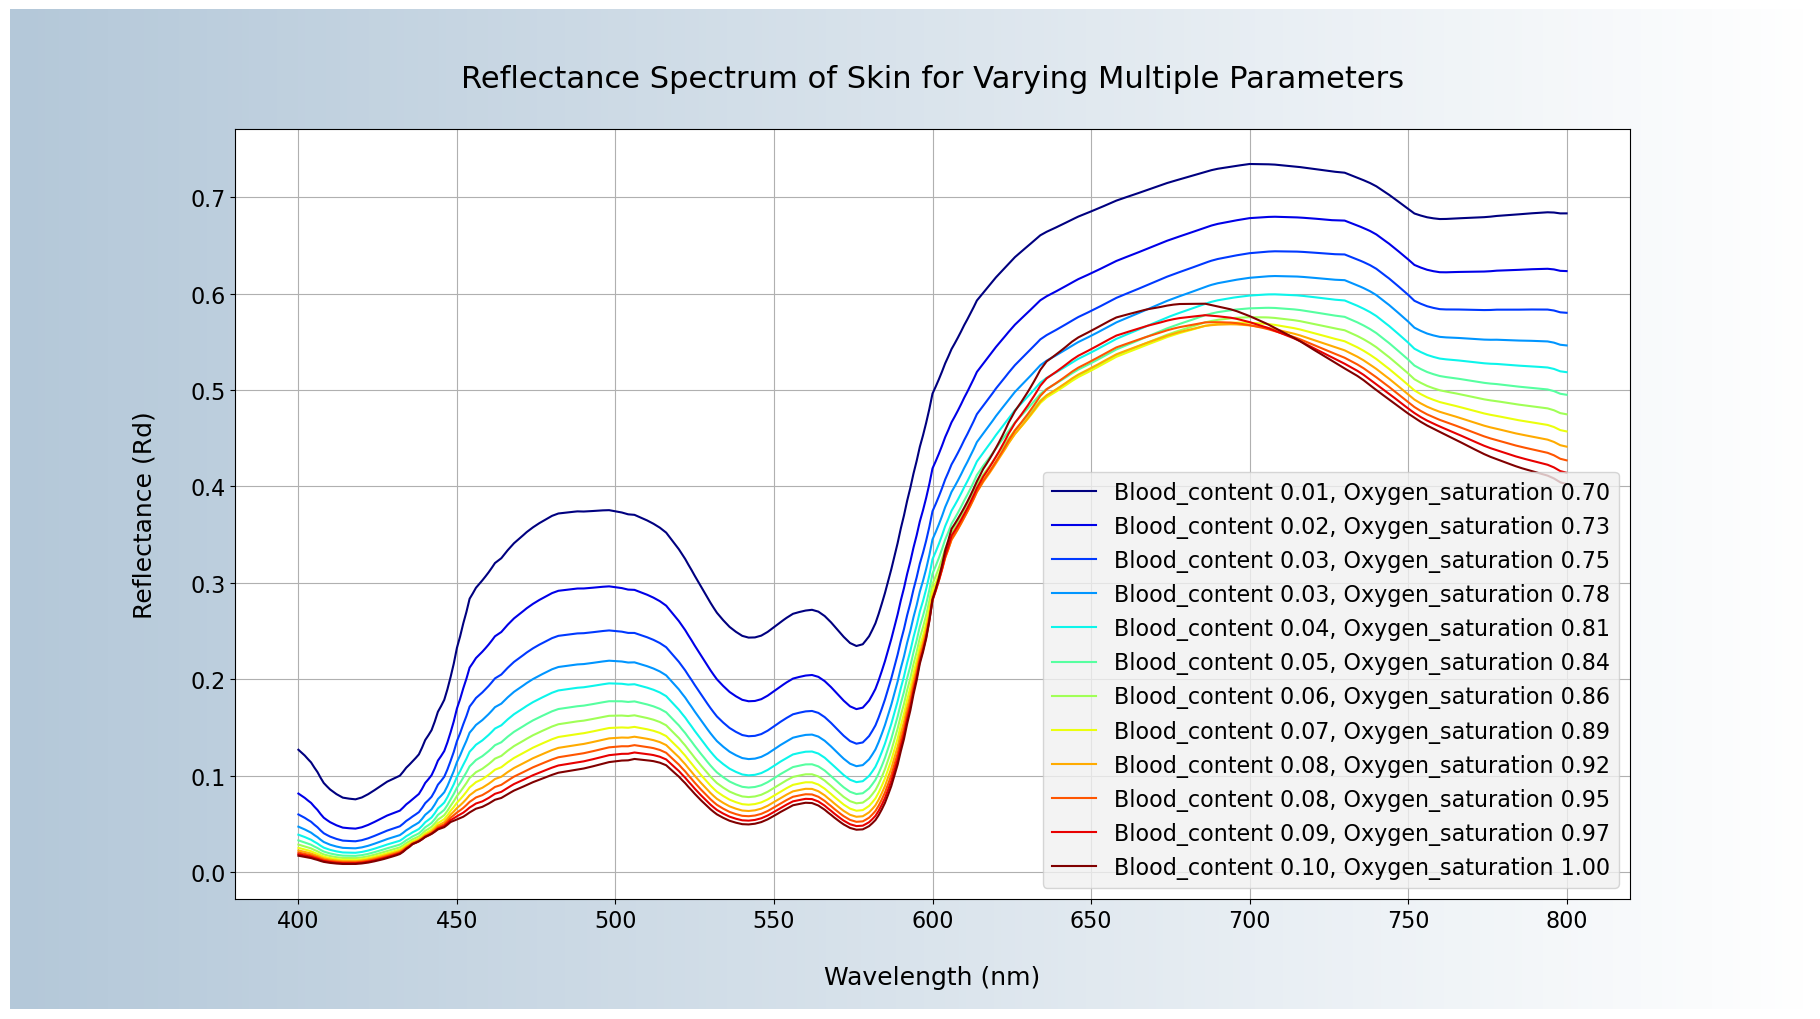

In [8]:
# Load spectral data
nmLIB, MU = load_spectral_data()

# Default parameters
default_params = {
    'blood_content': 0.02,  # 2% Blood content
    'oxygen_saturation': 0.95,  # 95% Oxygen saturation
    'water_content': 0.70,  # 70% Water content
    'refractive_index_ratio': 1.4,  # Refractive index ratio
    'melanin_content': 0.05,  # 5% Melanin content
    'collagen_content': 0.0  # 0% Collagen content
}

# Parameter ranges from literature
# References:
# 1. Blood content and oxygen saturation: Jacques, S. L. (2013). Optical properties of biological tissues: a review. Physics in Medicine & Biology, 58(11), R37.
# 2. Water content: Peters, A. M., et al. (1998). Changes in tissue water content measured with multiple-frequency bioimpedance. Nephrology Dialysis Transplantation, 13(6), 1514-1517.
# 3. Refractive index: Saidi, I. S., et al. (1995). Optical properties of skin and irradiated skin. Lasers in Surgery and Medicine, 16(2), 151-157.
# 4. Melanin content: Kollias, N., & Baqer, A. (1986). Quantitative assessment of UV-induced pigmentation and erythema. Photodermatology, 3(6), 327-330.
# 5. Collagen content: Anderson, R. R., & Parrish, J. A. (1981). The optics of human skin. Journal of Investigative Dermatology, 77(1), 13-19.

param_ranges = {
    'blood_content': (0.01, 0.1, 12),           # 1% to 10%
    'oxygen_saturation': (0.7, 1.0, 12),        # 70% to 100%
    # 'water_content': (0.6, 0.8, 12),            # 60% to 80%
    # 'refractive_index_ratio': (1.3, 1.5, 12),   # 1.3 to 1.5
    # 'melanin_content': (0.01, 0.1, 12),         # 1% to 10%
    # 'collagen_content': (0.0, 0.2, 12)          # 0% to 20%
}


plot_varying_multiple_parameters(param_ranges, nmLIB, MU, default_params, use_gradient=False)

# Plot spectra varying multiple parameters, with gradient
plot_varying_multiple_parameters(param_ranges, nmLIB, MU, default_params, use_gradient=True)
